NeMo Pipeline with Spanish and Optionally Enhanced

In [1]:
import nemo.collections.asr as nemo_asr
import numpy as np
from IPython.display import Audio, display
import librosa
from pydub import AudioSegment
import os
import wget
import matplotlib.pyplot as plt

import nemo
import glob

import pprint
pp = pprint.PrettyPrinter(indent=4)

import shutil

# source path
dir = os.path.dirname(os.getcwd())
AUDIO_FILENAME = os.path.join(dir, 'AudioProcessing/audios/User-7_record-665439596.897068.wav')
filnename_prefix = os.path.splitext(AUDIO_FILENAME)[0]

# create destination directory under AudioProcessing directory
ROOT = os.getcwd()
directory_name = 'NeMo_Spanish'
data_dir = os.path.join(ROOT,directory_name)

try:
    # if directory with the same name exists, print an error message
    if not os.path.exists(data_dir):
        os.makedirs(data_dir, exist_ok=True)
    else:
        raise OSError(f'Directory with name {data_dir} existed')
except OSError as err:
    print(err)
    
    # COMMENT OUT raise if I am not dealing with a new audio but just running this notebook for another time
    # raise


# TODO: If in the future I resample all the audio files in audios folder, I wouldn't need to copy the audio file to NeMo folder, and AUDIO_FILENAME would
# still be the path of the original audio file, and I will resample the audios outside of the NeMo scope.

# copy the file to NeMo directory
shutil.copy(AUDIO_FILENAME, data_dir)

# change AUDIO_FILENAME cause we want to use and resample the audio file in NeMo dir instead of changing the original audio file
AUDIO_FILENAME = os.path.join(dir, 'AudioProcessing/NeMo_Spanish/User-7_record-665439596.897068.wav')

# resampling the audio here in NeMo dir to be mono and 16kHz
sound = AudioSegment.from_file(AUDIO_FILENAME)
sound = sound.set_frame_rate(16000)
sound = sound.set_channels(1)
sound.export(AUDIO_FILENAME, format="wav")

signal, sample_rate = librosa.load(AUDIO_FILENAME, sr=None)
display(Audio(signal, rate=sample_rate))

# # test
# from pydub.utils import mediainfo
# info = mediainfo(AUDIO_FILENAME)
# print (info['sample_rate'])
# print (info['channels'])

[NeMo W 2022-08-28 18:31:55 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.


Directory with name /home/kangying/Desktop/Code/AudioProcessing/NeMo_Spanish existed


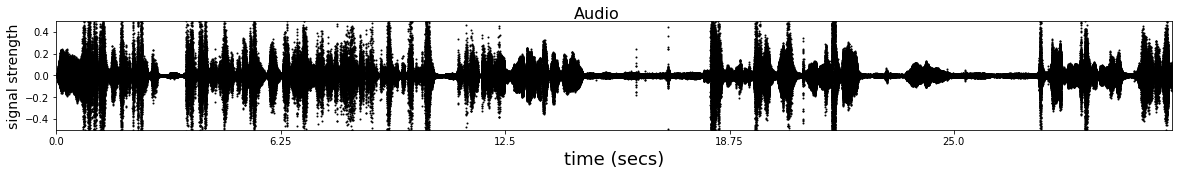

In [2]:
def display_waveform(signal,text='Audio',overlay_color=[]):
    fig,ax = plt.subplots(1,1)
    fig.set_figwidth(20)
    fig.set_figheight(2)
    plt.scatter(np.arange(len(signal)),signal,s=1,marker='o',c='k')
    if len(overlay_color):
        plt.scatter(np.arange(len(signal)),signal,s=1,marker='o',c=overlay_color)
    fig.suptitle(text, fontsize=16)
    plt.xlabel('time (secs)', fontsize=18)
    plt.ylabel('signal strength', fontsize=14);
    plt.axis([0,len(signal),-0.5,+0.5])
    time_axis,_ = plt.xticks();
    plt.xticks(time_axis[:-1],time_axis[:-1]/sample_rate);
    
COLORS="b g c m y".split()

def get_color(signal,speech_labels,sample_rate=16000):
    c=np.array(['k']*len(signal))
    for time_stamp in speech_labels:
        start,end,label=time_stamp.split()
        start,end = int(float(start)*16000),int(float(end)*16000),
        if label == "speech":
            code = 'red'
        else:
            code = COLORS[int(label.split('_')[-1])]
        c[start:end]=code
    
    return c 

# display the waveform (time domain)
display_waveform(signal)

Parameters Setting

In [3]:
from omegaconf import OmegaConf
import shutil

CONFIG_URL = "https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/offline_diarization_with_asr.yaml"
if not os.path.exists(os.path.join(data_dir,'offline_diarization_with_asr.yaml')):
    CONFIG = wget.download(CONFIG_URL, data_dir)
else:
    CONFIG = os.path.join(data_dir,'offline_diarization_with_asr.yaml')

cfg = OmegaConf.load(CONFIG)
# print(OmegaConf.to_yaml(cfg))

Create a manifest file where we specify the arguments expected by the Speaker Diatization script
1. manifest_filepath : Path to manifest file containing json lines of format: {"audio_filepath": "/path/to/audio_file", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": null, "rttm_filepath": "/path/to/rttm/file", "uem_filepath"="/path/to/uem/filepath"}
2. out_dir : directory where outputs and intermediate files are stored.
3. oracle_vad: If this is true then we extract speech activity labels from rttm files, if False then either
4. vad.model_path or external_manifestpath containing speech activity labels has to be passed.

In [4]:
# Create a manifest file for input with below format. 
# {"audio_filepath": "/path/to/audio_file", "offset": 0, "duration": null, "label": "infer", "text": "-", 
# "num_speakers": null, "rttm_filepath": "/path/to/rttm/file", "uem_filepath"="/path/to/uem/filepath"}
import json
meta = {
    'audio_filepath': AUDIO_FILENAME, 
    'offset': 0, 
    'duration':None, 
    'label': 'infer', 
    'text': '-', 
    'num_speakers': 3, 
    'rttm_filepath': None, 
    'uem_filepath' : None
}
with open(os.path.join(data_dir,'input_manifest.json'),'w') as fp:
    json.dump(meta,fp)
    fp.write('\n')

cfg.diarizer.manifest_filepath = os.path.join(data_dir,'input_manifest.json')
!cat {cfg.diarizer.manifest_filepath}

{"audio_filepath": "/home/kangying/Desktop/Code/AudioProcessing/NeMo_Spanish/User-7_record-665439596.897068.wav", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": 3, "rttm_filepath": null, "uem_filepath": null}


In [5]:
pretraind_speaker_model = 'titanet_large'
cfg.diarizer.manifest_filepath = cfg.diarizer.manifest_filepath
cfg.diarizer.out_dir = data_dir     # directory to store intermidiate files and prediction outputs

cfg.diarizer.speaker_embeddings.model_path = pretraind_speaker_model
cfg.diarizer.speaker_embeddings.parameters.window_length_in_sec = 1.5
cfg.diarizer.speaker_embeddings.parameters.shift_length_in_sec = 0.75
cfg.diarizer.clustering.parameters.oracle_num_speakers=True

# Using VAD generated from ASR timestamps
cfg.diarizer.asr.model_path = 'stt_es_conformer_ctc_large'    # this model is fine-tuned from English to Spanish
cfg.diarizer.oracle_vad = False # ----> Not using oracle VAD 
cfg.diarizer.ignore_overlap = False # ----> We want to consider overlaps
cfg.diarizer.asr.parameters.asr_based_vad = True
cfg.diarizer.asr.parameters.threshold=100 # ASR based VAD threshold: If 100, all silences under 1 sec are ignored.
cfg.diarizer.asr.parameters.decoder_delay_in_sec=0.2 # Decoder delay is compensated for 0.2 sec

Run ASR and get word stamps

In [6]:
from nemo.collections.asr.parts.utils.decoder_timestamps_utils import ASR_TIMESTAMPS

# create a decoder instance that returns an ASR model                                                                  
asr_ts_decoder = ASR_TIMESTAMPS(**cfg.diarizer)
asr_model = asr_ts_decoder.set_asr_model()

# run ASR
word_hyp, word_ts_hyp = asr_ts_decoder.run_ASR(asr_model)

print("Decoded word output dictionary: \n", word_hyp[filnename_prefix])
print("Word-level timestamps dictionary: \n", word_ts_hyp[filnename_prefix])

[NeMo I 2022-08-28 18:31:56 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-08-28 18:31:56 cloud:56] Found existing object /home/kangying/.cache/torch/NeMo/NeMo_1.11.0rc0/stt_es_conformer_ctc_large/7ee4dfbec197ef0c40416580d282b57d/stt_es_conformer_ctc_large.nemo.
[NeMo I 2022-08-28 18:31:56 cloud:62] Re-using file from: /home/kangying/.cache/torch/NeMo/NeMo_1.11.0rc0/stt_es_conformer_ctc_large/7ee4dfbec197ef0c40416580d282b57d/stt_es_conformer_ctc_large.nemo
[NeMo I 2022-08-28 18:31:56 common:910] Instantiating model from pre-trained checkpoint
[NeMo I 2022-08-28 18:31:59 mixins:170] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2022-08-28 18:31:59 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath:
    - - /data/dataset/train_bucketed/bucket1/tarred_audio_manifest.json
    - - /data/dataset/train_bucketed/bucket2/tarred_audio_manifest.json
    - - /data/dataset/train_bucketed/bucket3/tarred_audio_manifest.json
    - - /data/dataset/train_bucketed/bucket4/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 32
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 20
    min_duration: 0.1
    augmentor:
      noise:
        prob: 0.1
        manifest_path: /rir_noises_tarred/noises_20s_tarred/tarred_audio_manifest.json
        audio_tar_filepaths: /rir_noises_tarred/noises_20s_tarred/audio_{0..255}.tar
        min_snr_db: 0
        max_snr_db: 3

[NeMo I 2022-08-28 18:31:59 features:223] PADDING: 0
[NeMo I 2022-08-28 18:32:00 save_restore_connector:243] Model EncDecCTCModelBPE was successfully restored from /home/kangying/.cache/torch/NeMo/NeMo_1.11.0rc0/stt_es_conformer_ctc_large/7ee4dfbec197ef0c40416580d282b57d/stt_es_conformer_ctc_large.nemo.


[NeMo W 2022-08-28 18:32:00 decoder_timestamps_utils:67] `ctc_decode` was set to True. Note that this is ignored.


[NeMo I 2022-08-28 18:32:00 features:223] PADDING: 0
[NeMo I 2022-08-28 18:32:00 features:223] PADDING: 0


[NeMo W 2022-08-28 18:32:00 nemo_logging:349] /home/kangying/anaconda3/envs/NeMo/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    


[NeMo I 2022-08-28 18:32:00 decoder_timestamps_utils:654] Running ASR model stt_es_conformer_ctc_large
[NeMo I 2022-08-28 18:32:00 decoder_timestamps_utils:658] [1/1] FrameBatchASR: /home/kangying/Desktop/Code/AudioProcessing/NeMo_Spanish/User-7_record-665439596.897068.wav
Decoded word output dictionary: 
 ['palabras', 'especiales', 'para', 'los', 'próximos', 'capí', 'm', 'no', 'que', 'naturald', 'fo', 'en', 'elea', 'la', 'mí', 'sí', 'no', 'meternta', 'tengo', 'que', 'más']
Word-level timestamps dictionary: 
 [[7.04, 7.44], [7.72, 8.16], [8.48, 8.52], [8.68, 8.72], [8.84, 9.28], [9.48, 9.68], [12.16, 12.2], [12.64, 12.68], [12.88, 12.92], [13.2, 13.4], [13.56, 13.6], [13.92, 13.96], [14.12, 23.8], [27.52, 27.56], [27.68, 27.72], [27.92, 27.96], [28.16, 28.2], [28.32, 28.68], [28.84, 28.88], [29.2, 29.24], [30.68, 30.72]]


In [7]:
# all the available models
# nemo_asr.models.EncDecCTCModel.list_available_models()

Create an instance <code>asr_diar_offline</code> that matches diarization results with ASR outputs.

In [8]:
from nemo.collections.asr.parts.utils.diarization_utils import ASR_DIAR_OFFLINE

# pass cfg.diarizer to set up the params for both ASR and diarization
asr_diar_offline = ASR_DIAR_OFFLINE(**cfg.diarizer)
# set word_ts_anchor_offset variable that determines the a  chor position of each word. Here we use the default value
asr_diar_offline.word_ts_anchor_offset = asr_ts_decoder.word_ts_anchor_offset

[NeMo I 2022-08-28 18:34:46 speaker_utils:82] Number of files to diarize: 1


Run Diarization with the extracted word timestamps<br>
All the components for diarization is ready.

In [10]:
# diar_hyp: diarization inderence result written in [start time][end time][speaker] format
# diar_score: contains None since we did not provide rttm_filepath in the input manifest file
diar_hyp, diar_score = asr_diar_offline.run_diarization(cfg, word_ts_hyp)
print("Diarization hypothesis output: \n", diar_hyp[filnename_prefix])                                                                                

[NeMo I 2022-08-28 18:35:25 clustering_diarizer:154] Loading pretrained titanet_large model from NGC
[NeMo I 2022-08-28 18:35:25 cloud:56] Found existing object /home/kangying/.cache/torch/NeMo/NeMo_1.11.0rc0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-08-28 18:35:25 cloud:62] Re-using file from: /home/kangying/.cache/torch/NeMo/NeMo_1.11.0rc0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-08-28 18:35:25 common:910] Instantiating model from pre-trained checkpoint


[NeMo W 2022-08-28 18:35:25 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-08-28 18:35:25 modelPT:149] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-08-28 18:35:25 features:223] PADDING: 16
[NeMo I 2022-08-28 18:35:25 label_models:98] loss is Angular Softmax


[NeMo W 2022-08-28 18:35:25 nemo_logging:349] /home/kangying/anaconda3/envs/NeMo/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                    not been set for this class (TopKClassificationAccuracy). The property determines if `update` by
                    default needs access to the full metric state. If this is not the case, significant speedups can be
                    achieved and we recommend setting this to `False`.
                    We provide an checking function
                    `from torchmetrics.utilities import check_forward_full_state_property`
                    that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                    default for now) or if `full_state_update=False` can be used safely.
                    
      warnings.warn(*args, **kwargs)
    


[NeMo I 2022-08-28 18:35:25 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /home/kangying/.cache/torch/NeMo/NeMo_1.11.0rc0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-08-28 18:35:25 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-08-28 18:35:25 clustering_diarizer:279] Subsegmentation for embedding extraction: scale0, /home/kangying/Desktop/Code/AudioProcessing/NeMo_Spanish/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-08-28 18:35:25 clustering_diarizer:334] Extracting embeddings for Diarization
[NeMo I 2022-08-28 18:35:25 collections:297] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-08-28 18:35:25 collections:301] # 18 files loaded accounting to # 1 labels


  0%|          | 0/1 [00:00<?, ?it/s][NeMo W 2022-08-28 18:35:25 nemo_logging:349] /home/kangying/anaconda3/envs/NeMo/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    
100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
[NeMo W 2022-08-28 18:35:26 speaker_utils:424] cuda=False, using CPU for Eigen decomposition. This might slow down the clustering process.
100%|██████████| 1/1 [00:00<00:00,  3.61it/s]
[NeMo W 2022-08-28 18:35:26 speaker_utils:522] check if each ground truth RTTMs were present in provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2022-08-28 18:35:26 clustering_diarizer:453] Outputs are saved in /home/kangying/Desktop/Code/AudioProcessing/NeMo_Spanish directory
Diarization hypothesis output: 
 ['7.04 7.44 speaker_1', '7.72 8.16 speaker_2', '8.84 9.28 speaker_2', '9.48 9.68 speaker_2', '13.2 13.399999999999999 speaker_0', '14.12 15.245 speaker_1', '15.245 17.494999999999997 speaker_0', '17.495 23.8 speaker_1', '28.32 28.68 speaker_1']


<code>run_diarization()</code> function also creates <code>3_speakers.rttm</code> file. Let's check what's in it.

[   'SPEAKER User-7_record-665439596.897068 1   7.040   0.400 <NA> <NA> '
    'speaker_1 <NA> <NA>',
    'SPEAKER User-7_record-665439596.897068 1   7.720   0.440 <NA> <NA> '
    'speaker_2 <NA> <NA>',
    'SPEAKER User-7_record-665439596.897068 1   8.840   0.440 <NA> <NA> '
    'speaker_2 <NA> <NA>',
    'SPEAKER User-7_record-665439596.897068 1   9.480   0.200 <NA> <NA> '
    'speaker_2 <NA> <NA>',
    'SPEAKER User-7_record-665439596.897068 1   13.200   0.200 <NA> <NA> '
    'speaker_0 <NA> <NA>',
    'SPEAKER User-7_record-665439596.897068 1   14.120   1.125 <NA> <NA> '
    'speaker_1 <NA> <NA>',
    'SPEAKER User-7_record-665439596.897068 1   15.245   2.250 <NA> <NA> '
    'speaker_0 <NA> <NA>',
    'SPEAKER User-7_record-665439596.897068 1   17.495   6.305 <NA> <NA> '
    'speaker_1 <NA> <NA>',
    'SPEAKER User-7_record-665439596.897068 1   28.320   0.360 <NA> <NA> '
    'speaker_1 <NA> <NA>']


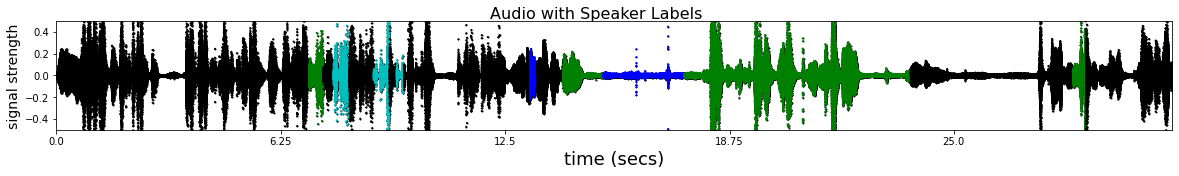

In [12]:
def read_file(path_to_file):
    with open(path_to_file) as f:
        contents = f.read().splitlines()
    return contents

predicted_speaker_label_rttm_path = f"{data_dir}/pred_rttms/{filnename_prefix}.rttm"
pred_rttm = read_file(predicted_speaker_label_rttm_path)

pp.pprint(pred_rttm)

from nemo.collections.asr.parts.utils.speaker_utils import rttm_to_labels
pred_labels = rttm_to_labels(predicted_speaker_label_rttm_path)

color = get_color(signal, pred_labels)
display_waveform(signal,'Audio with Speaker Labels', color)
display(Audio(signal,rate=16000))

Check the speaker-labeled ASR transcription output<br>
Now we've done all the processes for running ASR and diarization, let's match the diarization result with the ASR result and get the final output.

In [13]:
# this function matches diarization output diar_hyp with word_hyp using the timestamp info from word_ts_hyp
asr_diar_offline.get_transcript_with_speaker_labels(diar_hyp, word_hyp, word_ts_hyp)

[NeMo I 2022-08-28 18:37:35 diarization_utils:506] Creating results for Session: User-7_record-665439596.897068 n_spk: 3 
[NeMo I 2022-08-28 18:37:35 diarization_utils:443] Diarization with ASR output files are saved in: /home/kangying/Desktop/Code/AudioProcessing/NeMo_Spanish/pred_rttms


{'User-7_record-665439596.897068': OrderedDict([('status', 'Success'),
              ('session_id', 'User-7_record-665439596.897068'),
              ('transcription',
               'palabras especiales para los próximos capí m no que naturald fo en elea la mí sí no meternta tengo que más'),
              ('speaker_count', 3),
              ('words',
               [{'word': 'palabras',
                 'start_time': 7.04,
                 'end_time': 7.44,
                 'speaker_label': 'speaker_1'},
                {'word': 'especiales',
                 'start_time': 7.72,
                 'end_time': 8.16,
                 'speaker_label': 'speaker_2'},
                {'word': 'para',
                 'start_time': 8.48,
                 'end_time': 8.52,
                 'speaker_label': 'speaker_2'},
                {'word': 'los',
                 'start_time': 8.68,
                 'end_time': 8.72,
                 'speaker_label': 'speaker_2'},
                {'word': '

In [15]:
transcription_path_to_file = f"{data_dir}/pred_rttms/{filnename_prefix}.txt"
transcript = read_file(transcription_path_to_file)
pp.pprint(transcript)

[   '[00:07.04 - 00:07.44] speaker_1: palabras',
    '[00:07.72 - 00:09.68] speaker_2: especiales para los próximos capí',
    '[00:12.16 - 00:13.40] speaker_0: m no que naturald',
    '[00:13.56 - 00:23.80] speaker_1: fo en elea',
    '[00:27.52 - 00:27.56] speaker_0: la',
    '[00:27.68 - 00:30.72] speaker_1: mí sí no meternta tengo que más']


JSON output

In [16]:
transcription_path_to_file = f"{data_dir}/pred_rttms/{filnename_prefix}.json"
json_contents = read_file(transcription_path_to_file)
pp.pprint(json_contents)

[   '{',
    '    "status": "Success",',
    '    "session_id": "User-7_record-665439596.897068",',
    '    "transcription": "palabras especiales para los pr\\u00f3ximos '
    'cap\\u00ed m no que naturald fo en elea la m\\u00ed s\\u00ed no meternta '
    'tengo que m\\u00e1s",',
    '    "speaker_count": 3,',
    '    "words": [',
    '        {',
    '            "word": "palabras",',
    '            "start_time": 7.04,',
    '            "end_time": 7.44,',
    '            "speaker_label": "speaker_1"',
    '        },',
    '        {',
    '            "word": "especiales",',
    '            "start_time": 7.72,',
    '            "end_time": 8.16,',
    '            "speaker_label": "speaker_2"',
    '        },',
    '        {',
    '            "word": "para",',
    '            "start_time": 8.48,',
    '            "end_time": 8.52,',
    '            "speaker_label": "speaker_2"',
    '        },',
    '        {',
    '            "word": "los",',
    '            "star